---

In [1]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import random

---

In [2]:
def c(x, y):
    return np.abs(x - y)

# Define the initial and final distributions
mu = uniform(loc=-1, scale=2)
nu = uniform(loc=-2, scale=4)

# Generate samples from mu and nu
x_samples = mu.rvs(size=1000)
y_samples = nu.rvs(size=1000)

# Discretization
n_bins = 100
x_bins = np.linspace(-1, 1, n_bins+1)
y_bins = np.linspace(-2, 2, n_bins+1)
mu_hist, _ = np.histogram(x_samples, bins=x_bins, density=True)
nu_hist, _ = np.histogram(y_samples, bins=y_bins, density=True)

# Initialization of P
P_init = np.outer(mu_hist, nu_hist)
P_init /= P_init.sum()

# Apply optimal transport plan to set up the P_opt variable
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2
P_opt = np.zeros_like(P_init)
for i, x in enumerate(x_centers):
    y_left = x - 1
    y_right = x + 1
    y_left_idx = np.searchsorted(y_centers, y_left) - 1 
    y_right_idx = np.searchsorted(y_centers, y_right) - 1
    P_opt[i, y_left_idx] = 0.5 * mu_hist[i]
    P_opt[i, y_right_idx] = 0.5 * mu_hist[i]

# Generate new y samples based on the optimal transport plan
new_y_samples = []
for x in x_samples:
    x_idx = np.searchsorted(x_bins, x) - 1
    y_probs = P_opt[x_idx] / P_opt[x_idx].sum()
    y_idx = np.random.choice(np.arange(len(y_centers)), p=y_probs)
    new_y_samples.append(y_centers[y_idx])

new_y_samples = np.array(new_y_samples)

In [3]:
# Verify that Y follows the uniform distribution on (-2, 2)
d, p_value = stats.kstest(new_y_samples, 'uniform', args=(-2, 4))
follow_law = p_value > 0.05
print("Y follows uniform distribution on (-2, 2):", follow_law)

# Compute the expected cost
expected_cost = np.mean(c(x_samples, new_y_samples))
print("Expected cost E[c(X, Y)]:", expected_cost)

# Verify the inequality
lhs = np.mean(c(x_samples, new_y_samples))
rhs = np.sqrt(np.mean((x_samples - new_y_samples)**2))
print("Inequality holds:", lhs <= rhs)

# Verify the martingale property
martingale_diff = np.mean(new_y_samples - x_samples)
print("Martingale difference:", martingale_diff)
print("Martingale difference is close to 0:", np.isclose(martingale_diff, 0, atol=0.03))

Y follows uniform distribution on (-2, 2): True
Expected cost E[c(X, Y)]: 1.0085996127054089
Inequality holds: True
Martingale difference: -0.011642001223716015
Martingale difference is close to 0: True


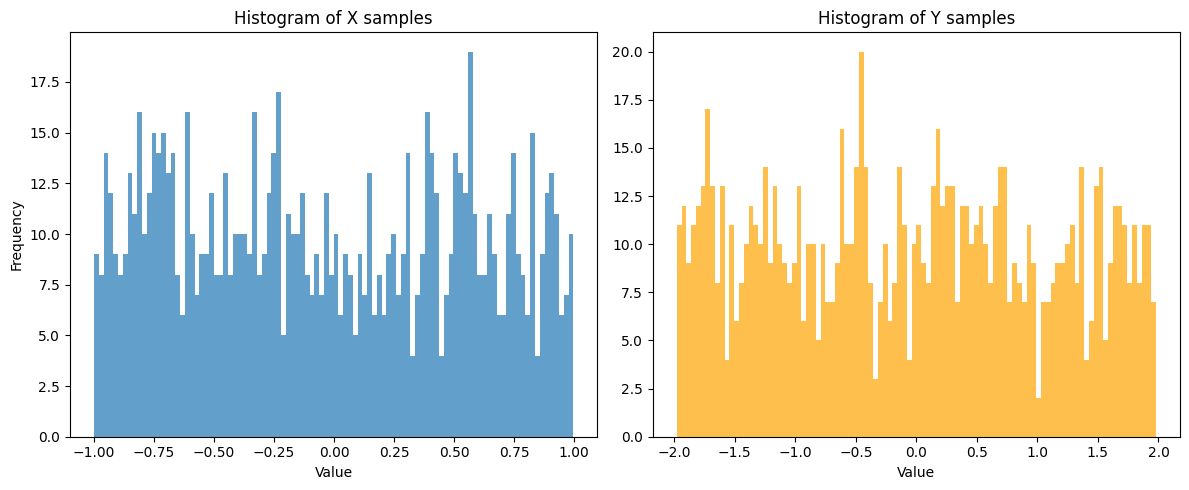

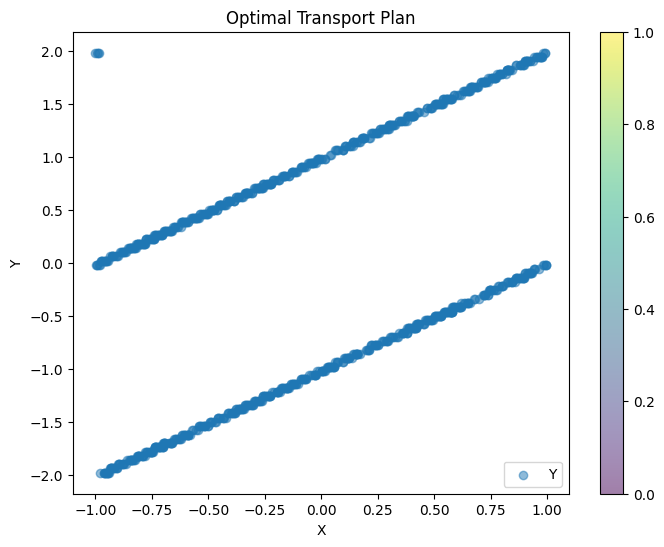

In [4]:
# Now, plotting the histogram of x_samples and y_samples
plt.figure(figsize=(12, 5))

# Histogram for x_samples
plt.subplot(1, 2, 1)
plt.hist(x_samples, bins=100, alpha=0.7, label='X samples')
plt.title('Histogram of X samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Histogram for y_samples
plt.subplot(1, 2, 2)
plt.hist(new_y_samples, bins=100, alpha=0.7, color='orange', label='Y samples')
plt.title('Histogram of Y samples')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

# Plot the optimal transport plan as a heatmap
plt.figure(figsize=(8, 6))
plt.scatter(x_samples, new_y_samples, alpha=0.5, label='Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Optimal Transport Plan')
plt.legend()
plt.colorbar()
plt.show()

---

In [18]:
def c(x, y):
    return np.abs(x - y)

def kl_divergence(P, Q):
    return np.sum(P * np.log(P / Q))

# Define the initial and final distributions
mu = uniform(loc=-1, scale=2)
nu = uniform(loc=-2, scale=4)

# Generate samples from mu and nu
x_samples = mu.rvs(size=1000)
y_samples = nu.rvs(size=1000)

# Discretization
n_bins = 100
x_bins = np.linspace(-1, 1, n_bins+1)
y_bins = np.linspace(-2, 2, n_bins+1)
mu_hist, _ = np.histogram(x_samples, bins=x_bins, density=True)
nu_hist, _ = np.histogram(y_samples, bins=y_bins, density=True)

# Initialization of P
P_init = np.outer(mu_hist, nu_hist)
P_init /= P_init.sum()

# Bregman projection
max_iter = 1000
tol = 1e-6
P = P_init.copy()
kl_divergences = []

for i in range(max_iter):
    # Projection onto marginal constraints
    P_marg = P.copy()
    P_marg /= P_marg.sum(axis=1, keepdims=True)
    P_marg *= mu_hist[:, np.newaxis]
    
    # Projection onto martingale constraints
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2
    y_centers = (y_bins[:-1] + y_bins[1:]) / 2
    P_mart = P_marg.copy()
    for j in range(n_bins):
        P_mart[j] *= x_centers[j] / np.dot(P_mart[j], y_centers)
    
    # Compute KL divergence
    kl_div = kl_divergence(P_mart, P)
    kl_divergences.append(kl_div)
    
    # Update P
    P = P_mart.copy()
    
    # Check convergence
    if kl_div < tol:
        break

# Generate new y samples based on the optimal transport plan
new_y_samples = []
for x in x_samples:
    x_idx = np.searchsorted(x_bins, x) - 1
    y_probs = P[x_idx] / P[x_idx].sum()
    y_idx = np.random.choice(np.arange(len(y_centers)), p=y_probs)
    new_y_samples.append(y_centers[y_idx])
new_y_samples = np.array(new_y_samples)

C:\Users\monde\AppData\Local\Temp\ipykernel_8428\2338239931.py:5: RuntimeWarning: invalid value encountered in log
  return np.sum(P * np.log(P / Q))


In [19]:
# Verify that Y follows the uniform distribution on (-2, 2)
d, p_value = stats.kstest(new_y_samples, 'uniform', args=(-2, 4))
follow_law = p_value > 0.05
print("Y follows uniform distribution on (-2, 2):", follow_law)

# Compute the expected cost
expected_cost = np.mean(c(x_samples, new_y_samples))
print("Expected cost E[c(X, Y)]:", expected_cost)

# Verify the inequality
lhs = np.mean(c(x_samples, new_y_samples))
rhs = np.sqrt(np.mean((x_samples - new_y_samples)**2))
print("Inequality holds:", lhs <= rhs)

# Verify the martingale property
martingale_diff = np.mean(new_y_samples - x_samples)
print("Martingale difference:", martingale_diff)
print("Martingale difference is close to 0:", np.isclose(martingale_diff, 0, atol=0.03))

Y follows uniform distribution on (-2, 2): False
Expected cost E[c(X, Y)]: 1.0494018263777476
Inequality holds: True
Martingale difference: 0.061538443966471436
Martingale difference is close to 0: False


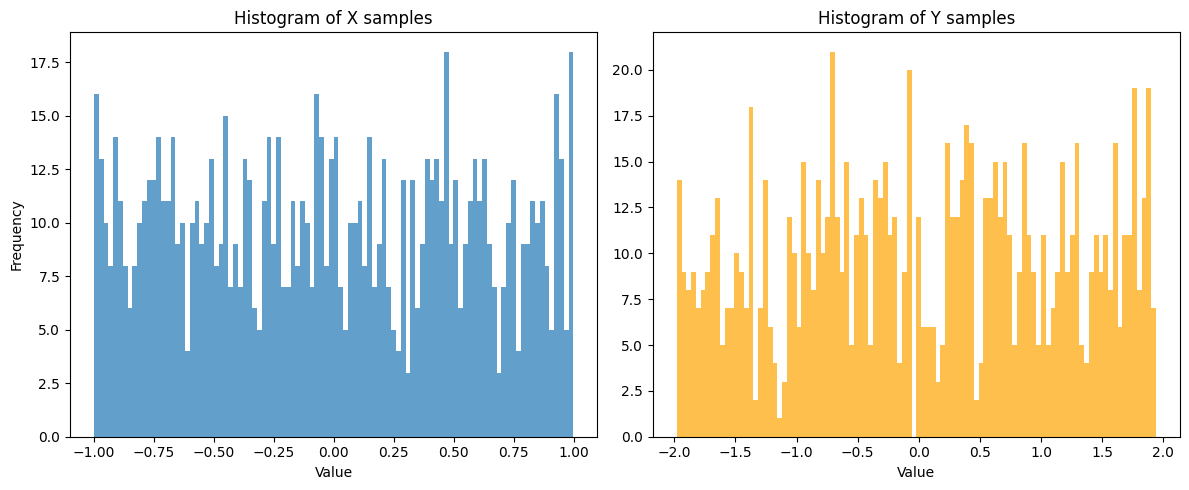

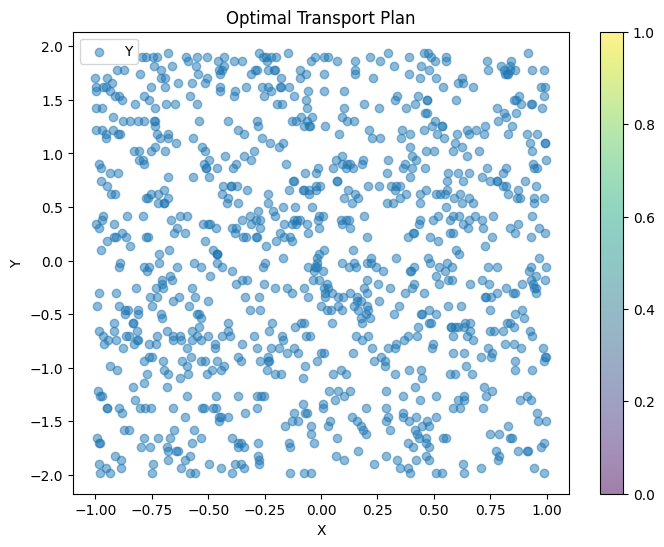

In [20]:
# Now, plotting the histogram of x_samples and y_samples
plt.figure(figsize=(12, 5))

# Histogram for x_samples
plt.subplot(1, 2, 1)
plt.hist(x_samples, bins=100, alpha=0.7, label='X samples')
plt.title('Histogram of X samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Histogram for y_samples
plt.subplot(1, 2, 2)
plt.hist(new_y_samples, bins=100, alpha=0.7, color='orange', label='Y samples')
plt.title('Histogram of Y samples')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

# Plot the optimal transport plan as a heatmap
plt.figure(figsize=(8, 6))
plt.scatter(x_samples, new_y_samples, alpha=0.5, label='Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Optimal Transport Plan')
plt.legend()
plt.colorbar()
plt.show()

---